<a href="https://colab.research.google.com/github/AntarikshVerma/AI_Agent_In_Langgraph/blob/main/music_composer_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Music Compositor using LangGraph

## Overview
This tutorial demonstrates how to build an AI-powered music composition system using LangGraph, a framework for creating workflows with language models. The system generates musical compositions based on user input, leveraging various components to create melody, harmony, rhythm, and style adaptations.

## Motivation
Creating music programmatically is a fascinating intersection of artificial intelligence and artistic expression. This project aims to explore how language models and graph-based workflows can be used to generate coherent musical pieces, providing a unique approach to AI-assisted music composition.

## Key Components
1. State Management: Utilizes a `MusicState` class to manage the workflow's state.
2. Language Model: Employs ChatOpenAI (GPT-4) for generating musical components.
3. Musical Functions:
   - Melody Generator
   - Harmony Creator
   - Rhythm Analyzer
   - Style Adapter
4. MIDI Conversion: Transforms the composition into a playable MIDI file.
5. LangGraph Workflow: Orchestrates the composition process using a state graph.
6. Playback Functionality: Allows for immediate playback of the generated composition.

## Method
1. The workflow begins by generating a melody based on user input.
2. It then creates harmony to complement the melody.
3. A rhythm is analyzed and suggested for the melody and harmony.
4. The composition is adapted to the specified musical style.
5. The final composition is converted to MIDI format.
6. The generated MIDI file can be played back using pygame.

The entire process is orchestrated using LangGraph, which manages the flow of information between different components and ensures that each step builds upon the previous ones.

## Conclusion
This AI Music Compositor demonstrates the potential of combining language models with structured workflows to create musical compositions. By breaking down the composition process into discrete steps and leveraging the power of AI, we can generate unique musical pieces based on simple user inputs. This approach opens up new possibilities for AI-assisted creativity in music production and composition.

<div style="text-align: center;">

<img src="https://github.com/AntarikshVerma/AI_Agent_In_Langgraph/blob/images/music_composer_agent_langgraph.svg?raw=1" alt="tts poem generator agent langgraph" style="width:50%; height:auto;">
</div>

In [25]:
# !pip install tavily-python==0.3.3
# !pip install duckduckgo_search==5.3.1b1
# !pip install beautifulsoup4==4.12.3
# !pip install openai==1.30.1
# !pip install langgraph==0.0.53
# !pip install langchain_core==0.2.0
# !pip install langchain_openai==0.1.7
# !pip install langchain-community==0.2.0
# !pip install langchain==0.2.0
# !pip install aiosqlite==0.20.0
# !pip install pygments==2.17.2
# !pip install pygraphviz==1.13
# !pip install gradio==4.31.3
# !apt install libgraphviz-dev
# !pip install pygraphviz
# !apt install libgraphviz-dev

In [34]:
# Import required libraries
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_openai import AzureChatOpenAI
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_community.callbacks import get_openai_callback
import music21
import pygame
import tempfile
import os
import random
from IPython.display import display, Image


## State Definition

Define the MusicState class to hold the workflow's state.

In [27]:
class MusicState(TypedDict):
    """Define the structure of the state for the music generation workflow."""
    musician_input: str  # User's input describing the desired music
    melody: str          # Generated melody
    harmony: str         # Generated harmony
    rhythm: str          # Generated rhythm
    style: str           # Desired musical style
    composition: str     # Complete musical composition
    midi_file: str       # Path to the generated MIDI file

## LLM Initialization

Initialize the Language Model (LLM) for generating musical components.

In [28]:
from google.colab import userdata
open_ai_key=userdata.get('OPENAI_API_KEY_GPT_4')
open_ai_base=userdata.get('OPENAI_API_URL_GPT_4')
api_version="2023-07-01-preview"

os.environ["OPENAI_API_VERSION"] = "2023-12-01-preview"
os.environ["AZURE_OPENAI_ENDPOINT"] = open_ai_base
os.environ["AZURE_OPENAI_API_KEY"] = open_ai_key


llm = AzureChatOpenAI(
    azure_deployment="gpt-4o",
    api_version="2024-02-15-preview",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


## Component Functions

Define the component functions for melody generation, harmony creation, rhythm analysis, style adaptation, and MIDI conversion.

In [30]:
def melody_generator(state: MusicState) -> Dict:
    """Generate a melody based on the user's input."""
    prompt = ChatPromptTemplate.from_template(
        "Generate a melody based on this input: {input}. Represent it as a string of notes in music21 format."
    )
    chain = prompt | llm
    melody = chain.invoke({"input": state["musician_input"]})
    return {"melody": melody.content}

def harmony_creator(state: MusicState) -> Dict:
    """Create harmony for the generated melody."""
    prompt = ChatPromptTemplate.from_template(
        "Create harmony for this melody: {melody}. Represent it as a string of chords in music21 format."
    )
    chain = prompt | llm
    harmony = chain.invoke({"melody": state["melody"]})
    return {"harmony": harmony.content}

def rhythm_analyzer(state: MusicState) -> Dict:
    """Analyze and suggest a rhythm for the melody and harmony."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze and suggest a rhythm for this melody and harmony: {melody}, {harmony}. Represent it as a string of durations in music21 format."
    )
    chain = prompt | llm
    rhythm = chain.invoke({"melody": state["melody"], "harmony": state["harmony"]})
    return {"rhythm": rhythm.content}

def style_adapter(state: MusicState) -> Dict:
    """Adapt the composition to the specified musical style."""
    prompt = ChatPromptTemplate.from_template(
        "Adapt this composition to the {style} style: Melody: {melody}, Harmony: {harmony}, Rhythm: {rhythm}. Provide the result in music21 format."
    )
    chain = prompt | llm
    adapted = chain.invoke({
        "style": state["style"],
        "melody": state["melody"],
        "harmony": state["harmony"],
        "rhythm": state["rhythm"]
    })
    return {"composition": adapted.content}

def midi_converter(state: MusicState) -> Dict:
    """Convert the composition to MIDI format and save it as a file."""
    # Create a new stream
    piece = music21.stream.Score()

    # Add the composition description to the stream as a text expression
    description = music21.expressions.TextExpression(state["composition"])
    piece.append(description)

    # Define a wide variety of scales and chords
    scales = {
        'C major': ['C', 'D', 'E', 'F', 'G', 'A', 'B'],
        'C minor': ['C', 'D', 'Eb', 'F', 'G', 'Ab', 'Bb'],
        'C harmonic minor': ['C', 'D', 'Eb', 'F', 'G', 'Ab', 'B'],
        'C melodic minor': ['C', 'D', 'Eb', 'F', 'G', 'A', 'B'],
        'C dorian': ['C', 'D', 'Eb', 'F', 'G', 'A', 'Bb'],
        'C phrygian': ['C', 'Db', 'Eb', 'F', 'G', 'Ab', 'Bb'],
        'C lydian': ['C', 'D', 'E', 'F#', 'G', 'A', 'B'],
        'C mixolydian': ['C', 'D', 'E', 'F', 'G', 'A', 'Bb'],
        'C locrian': ['C', 'Db', 'Eb', 'F', 'Gb', 'Ab', 'Bb'],
        'C whole tone': ['C', 'D', 'E', 'F#', 'G#', 'A#'],
        'C diminished': ['C', 'D', 'Eb', 'F', 'Gb', 'Ab', 'A', 'B'],
    }

    chords = {
        'C major': ['C4', 'E4', 'G4'],
        'C minor': ['C4', 'Eb4', 'G4'],
        'C diminished': ['C4', 'Eb4', 'Gb4'],
        'C augmented': ['C4', 'E4', 'G#4'],
        'C dominant 7th': ['C4', 'E4', 'G4', 'Bb4'],
        'C major 7th': ['C4', 'E4', 'G4', 'B4'],
        'C minor 7th': ['C4', 'Eb4', 'G4', 'Bb4'],
        'C half-diminished 7th': ['C4', 'Eb4', 'Gb4', 'Bb4'],
        'C fully diminished 7th': ['C4', 'Eb4', 'Gb4', 'A4'],
    }

    def create_melody(scale_name, duration):
        """Create a melody based on a given scale."""
        melody = music21.stream.Part()
        scale = scales[scale_name]
        for _ in range(duration):
            note = music21.note.Note(random.choice(scale) + '4')
            note.quarterLength = 1
            melody.append(note)
        return melody

    def create_chord_progression(duration):
        """Create a chord progression."""
        harmony = music21.stream.Part()
        for _ in range(duration):
            chord_name = random.choice(list(chords.keys()))
            chord = music21.chord.Chord(chords[chord_name])
            chord.quarterLength = 1
            harmony.append(chord)
        return harmony

    # Parse the user input to determine scale and style
    user_input = state['musician_input'].lower()
    if 'minor' in user_input:
        scale_name = 'C minor'
    elif 'major' in user_input:
        scale_name = 'C major'
    else:
        scale_name = random.choice(list(scales.keys()))

    # Create a 7-second piece (7 beats at 60 BPM)
    melody = create_melody(scale_name, 7)
    harmony = create_chord_progression(7)

    # Add a final whole note to make it exactly 8 beats (7 seconds at 60 BPM)
    final_note = music21.note.Note(scales[scale_name][0] + '4')
    final_note.quarterLength = 1
    melody.append(final_note)

    final_chord = music21.chord.Chord(chords[scale_name.split()[0] + ' ' + scale_name.split()[1]])
    final_chord.quarterLength = 1
    harmony.append(final_chord)

    # Add the melody and harmony to the piece
    piece.append(melody)
    piece.append(harmony)

    # Set the tempo to 60 BPM
    piece.insert(0, music21.tempo.MetronomeMark(number=60))

    # Create a temporary MIDI file
    with tempfile.NamedTemporaryFile(delete=False, suffix='.mid') as temp_midi:
        piece.write('midi', temp_midi.name)

    return {"midi_file": temp_midi.name}


## Graph Construction

Construct the LangGraph workflow for the AI Music Collaborator.

In [31]:
# Initialize the StateGraph
workflow = StateGraph(MusicState)

# Add nodes to the graph
workflow.add_node("melody_generator", melody_generator)
workflow.add_node("harmony_creator", harmony_creator)
workflow.add_node("rhythm_analyzer", rhythm_analyzer)
workflow.add_node("style_adapter", style_adapter)
workflow.add_node("midi_converter", midi_converter)

# Set the entry point of the graph
workflow.set_entry_point("melody_generator")

# Add edges to connect the nodes
workflow.add_edge("melody_generator", "harmony_creator")
workflow.add_edge("harmony_creator", "rhythm_analyzer")
workflow.add_edge("rhythm_analyzer", "style_adapter")
workflow.add_edge("style_adapter", "midi_converter")
workflow.add_edge("midi_converter", END)

# Compile the graph
app = workflow.compile()

## Display Graph

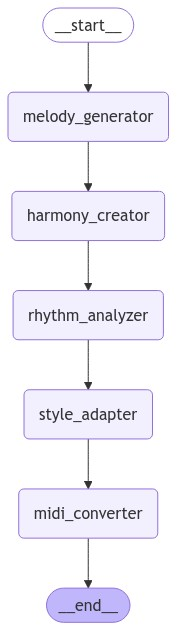

In [32]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run the Workflow

Execute the AI Music Collaborator workflow to generate a musical composition.

In [33]:
# Define input parameters
inputs = {
    "musician_input": "Create a happy piano piece in C major",
    "style": "Romantic era"
}

# Invoke the workflow
result = app.invoke(inputs)

print("Composition created")
print(f"MIDI file saved at: {result['midi_file']}")

KeyboardInterrupt: 